<img src="https://www.nps.gov/yose/blogs/images/Speeding-Kills-Bears.jpg" />

In [1]:
import numpy as np
import torch
import tensorflow as tf
import cupy as cp
%matplotlib notebook
import matplotlib.pyplot as plt

In [7]:
N = 2**20
# numpy
x_np = np.random.rand(N) + 1j * np.random.rand(N)
# torch
x_torch = torch.rand((N,2))
x_torch_cuda = torch.rand((N,2)).cuda(0)
# cupy - it doesn't play nice with other packages, so it get's its own gpu
cp.cuda.Device(1).use()
x_cp = cp.random.rand(N) + 1j * cp.random.rand(N)
# tensorflow
with tf.device('/gpu:0'):
    sess = tf.Session()
    x_tf = tf.complex(tf.random.normal((N,1)),tf.random.normal((N,1)))
    tf_fft = tf.fft(x_tf)
    
print(" pure python")
out_numpy = %timeit -o -r 1 np.fft.fft(x_np)
print("\n python, but torch")
out_torch = %timeit -o -r 1 torch.fft(x_torch,1)
print("\n torch with cuda")
out_torch_cuda = %timeit -o -r 1 torch.fft(x_torch_cuda,1)
print("\n cupy")
cp.cuda.Device(1).use()
out_cupy = %timeit -o -r 1 cp.fft.fft(x_cp)
print("\n tensorflow")
out_tf_cuda = %timeit -o -r 3 sess.run(tf_fft)

del x_np, x_torch, x_torch_cuda, x_cp
torch.cuda.empty_cache()

 pure python
9.09 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)

 python, but torch
4.16 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)

 torch with cuda
90.1 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)

 cupy
485 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)

 tensorflow
1.97 ms ± 50.3 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [2]:
pows = np.arange(2,28,1)

def time_fft(n, i):
    N = 2**n
    if i == 0:# numpy
        x_np = np.random.rand(N) + 1j * np.random.rand(N)
        temp = %timeit -q -o -r 1 np.fft.fft(x_np)
        del x_np
    elif i == 1:# torch
        x_torch = torch.rand((N,2))
        temp = %timeit -q -o -r 1 torch.fft(x_torch,1)
        del x_torch
    elif i == 2:# torch
        x_torch_cuda = torch.rand((N,2)).cuda(0)
        temp = %timeit -q -o -r 1 torch.fft(x_torch_cuda,1)
        del x_torch_cuda
        torch.cuda.empty_cache()
    elif i == 3: # cupy
        cp.cuda.Device(1).use()
        x_cp = cp.random.rand(N) + 1j * cp.random.rand(N)
        temp = %timeit -q -o -r 1 cp.fft.fft(x_cp)
        del x_cp
    elif i == 4:# tensorflow
        with tf.device('/gpu:0'):
            sess = tf.Session()
            x_tf = tf.complex(tf.random.normal((N,1)),tf.random.normal((N,1)))
            tf_fft = tf.fft(x_tf)
        temp = %timeit -q -o -r 3 sess.run(tf_fft)
        
    return temp.average

# This takes a long time, run only once if you mean it
times = np.zeros((5,len(pows)))
for j in range(5):
    times[j,:] = [time_fft(p,j) for p in pows]



<IPython.core.display.Javascript object>


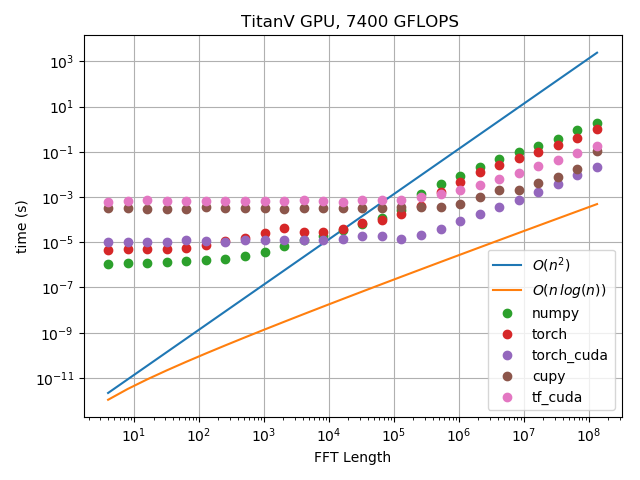

In [4]:
n = 2**pows
_, ax = plt.subplots()
GFLOPS = 7400
ax.set_title(f"TitanV GPU, {GFLOPS} GFLOPS ")
ax.loglog(n,n**2 / GFLOPS/1e9, label = r"$O(n^2)$")
ax.loglog(n, n*np.log2(n) / GFLOPS/1e9, label = r"$O(n\,log(n))$")
labels = ["numpy", "torch", "torch_cuda", "cupy", "tf_cuda"]
[ax.loglog(2**pows, times[j,:], 'o',label= labels[j]) for j in range(5)]

ax.set_ylabel("time (s)")
ax.set_xlabel("FFT Length")
ax.grid()

plt.legend()
plt.tight_layout()
plt.show()

In [6]:
[print(torch.cuda.get_device_name(j)) for j in range(torch.cuda.device_count())]

TITAN V
GeForce GTX 1080 Ti


[None, None]